### DLP Lab5
Goal of this lab is to to implement a conditional seq2seq VAE for English tense conversion
1. Tense conversion: ‘access’ to ‘accessing’, or ‘accessed’ to ‘accesses’
2. Generative model: Gaussian noise + tense -> access, accesses, accessing, accessed

#### Requirment
1. Implement a conditional seq2seq VAE.
    * Modify encoder, decoder, and training functions
    * Implement evaluation function, dataloader, and reparameterization trick.
2. Plot and **compare** the CrossEntropy loss, KL loss and BLEU-4 score of testing data curves during training with different settings of your model
    * Teacher forcing ratio
    * KL annealing schedules (two methods)
3. Output the conversion results between tenses (from tense A to tense B)
4. Output the results generated by a Gaussian noise with 4 tenses.

#### Implement detail
1. Use LSTM
2. Log variance
3. Condition (tense)
    * Simply concatenate to the hidden_0 and z
    * Embed your condition to high dimensional space (or simply use one-hot)
4. KL lost annealing
    * Monotonic
    * Cyclical
5. Adopt BLEU-4 score function in NLTK (average 10 testing scores)
6. Adopt Gaussian_score() to compute the generation score
    * Random sample 100 noise to generate 100 words with 4 different tenses(totally 400 words)
    * 4 words should exactly match the training data

#### Hyper parameters
* LSTM hidden size: 256 or 512
* Latent size: 32
* Condition embedding size: 8
* Teacher forcing ratio: 0~1 (>0.5) (??? 
* KL weight: 0~1 (???
* Learning rate: 0.05
* Optimizer: SGD
* Loss function: torch.nn.CrossEntropyLoss()


Date: 2020/05/12
* 1-4版本, 用in_layer把latent vector擴充成hidden size
* encoder丟一個單字
* 有batch, padding

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import gc
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
SOS_token = 0
EOS_token = 1
#----------Hyper Parameters----------#
hidden_size = 256
laten_size = 32
condition_size = 4
#The number of vocabulary
vocab_size = 30
teacher_forcing_ratio = 0.7
empty_input_ratio = 0.1
KLD_weight = 0.0
learning_rate = 0.01

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Fetch data
* train.txt: Each training pair includes 4 words: simple present(sp), third person(tp), present progressive(pg), simple past(p)
* test.txt: Each training pair includes 2 words with different combination of tenses

In [4]:
def getData(mode):
    assert mode == 'train' or mode == 'test'
    if mode == 'train':
        data = pd.read_csv('./data/'+mode+'.txt', delimiter=' ', header=None)
    else:
        data = []
        with open('./data/test.txt','r') as fp:
            for line in fp:
                word = line.split(' ')
                word[1] = word[1].strip('\n')
                data.extend([word])
    return data

#### Vocabulary

In [5]:
class Vocabuary():
    def __init__(self):
        self.word2index = {'SOS': 0, 'EOS': 1, 'PAD': 2, 'UNK': 3}
        self.index2word = {0: 'SOS', 1: 'EOS', 2: 'PAD', 3: 'UNK'}
        self.n_words = 4
        self.max_length = 0
        self.build_vocab(getData('train'))
        

    # input the training data and build vocabulary
    def build_vocab(self, corpus):        
        for idx in range(corpus.shape[0]):
            for word in corpus.iloc[idx,:]:
                if len(word) > self.max_length:
                    self.max_length = len(word)
                    
                for char in word:
                    if char not in self.word2index:
                        self.word2index[char] = self.n_words
                        self.index2word[self.n_words] = char
                        self.n_words += 1 
        self.max_length +=2
                    
    # convert word in indices
    def word2indices(self, word, add_eos=True, add_sos=True):
        indices = [self.word2index[char] if char in self.word2index else 3 for char in word]

        if add_sos:
            indices.insert(0, 0)
        if add_eos:
            indices.append(1)
            
        # padding input of same target into same length
        indices.extend([2]*(self.max_length-len(word)))
            
        return np.array(indices)
    
    # convert indices to word
    def indices2word(self, indices):
        # ignore indices after EOS
        new_indices = []
        for idx in indices:
            new_indices.append(idx)
            if idx == self.word2index['EOS']:
                break
                    
        word = [self.index2word[idx] for idx in new_indices if idx > 2 ]
        return ''.join(word)

In [6]:
v = Vocabuary()
t = "exculpated"
idx = v.word2indices(t)
print(idx)
t = v.indices2word(idx)
print(t)

[ 0 12 29 14 15 20 17  4 13 12  7  1  2  2  2  2  2  2  2]
exculpated


#### DataLoader

In [7]:
class TenseLoader(data.Dataset):
    def __init__(self, mode, vocab):
        self.mode = mode   
        self.data = getData(self.mode)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_tensor = []
        if self.mode == 'train':
            for word in self.data.iloc[index,:]:
                data_tensor.append(torch.tensor(self.vocab.word2indices(word)))
#             data_tensor = torch.tensor(data_tensor)
        else:
            condition = [["sp", "p"], ["sp", "pg"], ["sp", "tp"], ["sp", "tp"], ["p", "tp"], 
                        ["sp", "pg"], ["p", "sp"], ["pg", "sp"], ["pg", "p"], ["pg", "tp"]]
            order = {'sp':0, 'tp':1, 'pg':2, 'p':3}
            
            input_tense = order[condition[index][0]]
            input_tensor = torch.tensor(self.vocab.word2indices(self.data[index][0]))
            target_tense = order[condition[index][1]]
            target_tensor = torch.tensor(self.vocab.word2indices(self.data[index][1]))
            
            data_tensor = [(input_tense, input_tensor), (target_tense, target_tensor)]

        return data_tensor

In [8]:
trainset = TenseLoader('train', v)
trainset[12]

[tensor([ 0,  4, 14, 21, 10, 12, 22, 12,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2]),
 tensor([ 0,  4, 14, 21, 10, 12, 22, 12,  9,  1,  2,  2,  2,  2,  2,  2,  2,  2,
          2]),
 tensor([ 0,  4, 14, 21, 10, 12, 22, 10,  6, 11,  1,  2,  2,  2,  2,  2,  2,  2,
          2]),
 tensor([ 0,  4, 14, 21, 10, 12, 22, 12,  7,  1,  2,  2,  2,  2,  2,  2,  2,  2,
          2])]

In [9]:
testset = TenseLoader('test', v)
testset[0]

[(0, tensor([0, 4, 5, 4, 6, 7, 8, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])),
 (3,
  tensor([ 0,  4,  5,  4,  6,  7,  8,  6, 12,  7,  1,  2,  2,  2,  2,  2,  2,  2,
           2]))]

#### Show reslut
* Crossentropy loss curve
* KL loss curve
* BLEU-4 score curve

In [10]:
def show_result(scores, losses):  
    bleu_score, gaussian_score = scores
    c_loss, kl_loss = losses
    
    plt.figure(figsize=(10, 6))
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("CrossEntropy Loss Curve", fontsize=18)
    plt.plot(c_loss)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("KL Loss Curve", fontsize=18)
    plt.plot(kl_loss)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.ylabel("Score")
    plt.xlabel("Epochs")
    plt.title("BLEU Score Curve", fontsize=18)
    plt.plot(bleu_score)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.ylabel("Score")
    plt.xlabel("Epochs")
    plt.title("Gaussian Score Curve", fontsize=18)
    plt.plot(gaussian_score)
    plt.show()

#### Condition
concatenate the condition part with the initial hidden part 
* nn.Embedding
* One-hot

In [11]:
def condition_embedding(condition_size, batch_size=1, condition=None):
    order = {'sp':0, 'tp':1, 'pg':2, 'p':3}
    one_hot = {0:[1, 0, 0, 0], 1:[0, 1, 0, 0], 2:[0, 0, 1, 0], 3:[0, 0, 0, 1]}
    
    if condition != None:
        embedded_tense = torch.tensor(one_hot[condition], dtype=torch.float).view(1, -1)
    else: 
        embedded_tense = []
        for o in order.values():
            embedded = torch.tensor(one_hot[o], dtype=torch.float).view(1, -1)
            embedded_cp = embedded
            
            # expand batch dim, (4, condition_size) to (4, batch_size, condition_size)
            for i in range(batch_size-1):
                embedded = torch.cat((embedded, embedded_cp), 0)
            embedded_tense.append(embedded)
        
    return embedded_tense
                     
condition_embedding(condition_size, 32)

[tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]), tensor([[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],


### Evaluation

In [12]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    """
    reference = 'accessed'
    output = 'access'
    return BLEU score
    """
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [13]:
def BLEU_predict(encoder, decoder, vocab, batch_size=1, condition_size=8, plot_pred=False):
    testset = TenseLoader('test', vocab)
    outputs = []
    
    with torch.no_grad():
    
        for idx in range(len(testset)):
            input_tense = testset[idx][0][0]
            input_embedded_tense = condition_embedding(condition_size, condition=input_tense) # (1, condition_szie)
            input_tensor = testset[idx][0][1].to(device) # (seq_len)

            target_tense = testset[idx][1][0]
            target_embedded_tense = condition_embedding(condition_size, condition=target_tense)
            target_tensor = testset[idx][1][1].to(device)

            batch_size = 1
            
            # transpose tensor from (batch_size, tense, seq_len) to (tense, seq_len, batch_size)
            input_tensor = input_tensor.view(-1, 1) # (seq_len, batch_size)
            target_tensor = target_tensor.view(-1, 1)

            # init encoder hidden state and cat condition
            encoder_hidden = encoder.initHidden(input_embedded_tense, batch_size)

            # calculate number of time step
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            

            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # reparameterization trick
            mu, logvar = encoder.variational(encoder_hidden)
            reparameterized_state = reparameterize(mu, logvar)
            reparameterized_state = decoder.in_layer(reparameterized_state)

            # init decoder hidden state and cat condition
            decoder_hidden = decoder.initHidden(reparameterized_state, target_embedded_tense, batch_size)
            
            decoder_input = torch.tensor([[SOS_token] for i in range(batch_size)], device=device)
            
            output = torch.zeros(target_length, batch_size)

            #----------sequence to sequence part for decoder----------#
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input
                output[di] = decoder_input
            
            # transpose tensor from (target_length, batch_size) to (batch_size, target_length)
            output = output.transpose(0, 1).view(-1)
         
            outputs.append(vocab.indices2word(output.data.numpy()))

    return outputs

In [14]:
# print the prediction and return the bleu score
def BLEU_score(prediction, plot_pred=False):
    data = getData('test')

    bleu_total = 0
    for idx in range(len(prediction)):
        bleu_total += compute_bleu(prediction[idx], data[idx][1])

        if plot_pred:
            output = "\ninput:  {}\ntarget: {}\npred:   {}".format(data[idx][0], data[idx][1], prediction[idx])
            print ("="*30+output)

    return bleu_total/len(prediction)

In [15]:
def Gaussian_predict(encoder, decoder, vocab, batch_size=64, laten_size=32, condition_size=8, plot_pred=False):
    outputs = []

    with torch.no_grad():    
        batch_size = 100

        # sample 100 Gaussian
        laten_variable = torch.randn((batch_size, laten_size), device=device).view(1, batch_size, -1)

        # get 4 tense embedding tensor
        embedded_tenses = condition_embedding(condition_size , batch_size)

        # record outputs
        output_tensors = torch.zeros(4, vocab.max_length, batch_size)# (tense, seq_len, batch_size)

        # 4 tense iteration
        for index, embedded_tense in enumerate(embedded_tenses):

            decoder_input = torch.tensor([[SOS_token] for i in range(batch_size)], device=device)

            output = torch.zeros(vocab.max_length, batch_size)

            # init decoder hidden state and cat condition
            decoder_hidden = decoder.initHidden(decoder.in_layer(laten_variable), embedded_tense, batch_size)

            #----------sequence to sequence part for decoder----------#
            for di in range(vocab.max_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input
                output[di] = decoder_input

            # get predict tensors
            output_tensors[index] = output

        # transpose tensor from (tense, seq_len, batch_size) to (batch_size, tense, seq_len)
        output_tensors = output_tensors.permute(2, 0, 1)

        # convert input into string
        for idx in range(batch_size):
            outputs.append([vocab.indices2word(tense.data.numpy()) for tense in output_tensors[idx]])

    return outputs

In [16]:
# compute generation score
def Gaussian_score(predictions, plot_pred=False):
    """
    the order should be : simple present, third person, present progressive, past
    predictions = [['consult', 'consults', 'consulting', 'consulted'],...]
    return Gaussian_score score
    """
    score = 0
    words_list = []
    with open('./data/train.txt','r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for idx, t in enumerate(predictions):
            if plot_pred:
                print (t)
            for idxj, i in enumerate(words_list):
                if t == i:
                    score += 1
    return score/len(predictions)

In [17]:
def evaluate(encoder, decoder, vocab, batch_size=64, laten_size=32, condition_size=8, plot_pred=False):
    # predict train.txt for gaussian score
    predictions = Gaussian_predict(encoder, decoder, vocab, batch_size=batch_size, laten_size=laten_size, condition_size=condition_size, plot_pred=plot_pred)
    
    # compute Gaussian score
    gaussian_score = Gaussian_score(predictions, plot_pred=plot_pred)
    if plot_pred:
        print ("Gaussian score: %.2f"%gaussian_score)

    # predict test.txt for bleu score
    predictions = BLEU_predict(encoder, decoder, vocab, batch_size=1, condition_size=condition_size, plot_pred=False)
            
    # compute BLEU score
    bleu_score = BLEU_score(predictions, plot_pred=plot_pred)
    if plot_pred:
        print ("BLEU score: %.2f"%bleu_score)
    
    return bleu_score, gaussian_score

#### Reparameterization Trick

In [18]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

### Encoder

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, laten_size, condition_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        
        self.fc1 = nn.Linear(hidden_size+condition_size, laten_size)
        self.fc2 = nn.Linear(hidden_size+condition_size, laten_size)

        self.embedding = nn.Embedding(input_size, hidden_size+condition_size)
        self.lstm = nn.LSTM(hidden_size+condition_size, hidden_size+condition_size)

    def forward(self, inputs, hidden):
        output = self.embedding(inputs)
        output, hidden = self.lstm(output, hidden)
        return output, hidden
    
    def variational(self, hidden):
        return self.fc1(hidden[0]), self.fc2(hidden[0])

    def initHidden(self, embedded_tense, batch_size=64):
        embedded_tense = embedded_tense.to(device).view(1, batch_size, -1)
        zeros = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return (torch.cat((zeros, embedded_tense), 2),
                torch.cat((zeros, embedded_tense), 2))

### Decoder

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, condition_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.condition_size = condition_size

        self.in_layer = nn.Linear(latent_size, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size+condition_size)
        self.lstm = nn.LSTM(hidden_size+condition_size, hidden_size+condition_size)
        self.out = nn.Linear(hidden_size+condition_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, -1, self.hidden_size+self.condition_size)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self, hidden_state, embedded_tense, batch_size):
        #print(hidden_state.shape)
        embedded_tense = embedded_tense.to(device).view(1, batch_size, -1)
        zeros = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return (torch.cat((hidden_state, embedded_tense), 2),
                torch.cat((zeros, embedded_tense), 2))

### Train
* Use teacher forcing
* Use KL loss annealing

In [30]:
def kl_annealing(epochs, mode):
    assert mode == "monotonic" or mode == "cyclical"
    if mode == "monotonic":
        if epochs > 500:
            KLD_weight = 0.1
        else:
            KLD_weight = 0.0002 * epochs
    else:
        if epochs%500 > 250:
            KLD_weight = 0.1
        else:
            KLD_weight = 0.0004 * (epochs%500)
    return KLD_weight

In [22]:
def compute_kl_loss(mu, logvar):
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

In [31]:
# save model every epoch
def train(input_tensors, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, epochs, condition_size, teacher_forcing_ratio):
#     batch_size = input_tensors.size(0)
    batch_size = input_tensors[0].size(0)
    # get 4 tense embedding tensor
    embedded_tenses = condition_embedding(condition_size, batch_size)
    
    # loss for 4 tense
    kl_loss_total = 0
    ce_loss_total = 0
    
    # transpose tensor from (batch_size, tense, seq_len) to (tense, seq_len, batch_size)
#     input_tensors = input_tensors.permute(1, 2, 0)
    
    # 4 tense iteration
    for index, embedded_tense in enumerate(embedded_tenses):
        # embedded_tense.to(device)
        input_tensor = input_tensors[index].to(device) 
        input_tensor = input_tensor.transpose(0, 1) # (seq_len, batch_size)
    
        # init encoder hidden state and cat condition
        encoder_hidden = encoder.initHidden(embedded_tense, batch_size)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # calculate number of time step
        input_length = input_tensor.size(0)

        loss = 0
        ce_loss = 0

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            
        # reparameterization trick
        mu, logvar = encoder.variational(encoder_hidden)
        reparameterized_state = reparameterize(mu, logvar)
        reparameterized_state = decoder.in_layer(reparameterized_state)
        
        # calculate kl loss
        kl_loss = compute_kl_loss(mu, logvar) / batch_size
        kl_loss_total += kl_loss
        loss += kl_annealing(epochs, "cyclical") * kl_loss
        
        # init decoder hidden state and cat condition
        decoder_hidden = decoder.initHidden(reparameterized_state, embedded_tense, batch_size)
        
        decoder_input = torch.tensor([[SOS_token] for i in range(batch_size)], device=device)

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        #----------sequence to sequence part for decoder----------#
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(input_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
                _, indx = torch.max(decoder_output, 1)
                ce_loss += criterion(decoder_output, input_tensor[di])
                decoder_input = input_tensor[di]  # Teacher forcing
                
        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(input_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                ce_loss += criterion(decoder_output, input_tensor[di])
#                 if decoder_input.item() == EOS_token:
#                     break

        loss += ce_loss
        ce_loss_total += (ce_loss.item()/input_length)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    return ce_loss_total/4, kl_loss_total/4

In [32]:
def trainIters(encoder, decoder, vocab, n_iters, print_every=1000, plot_every=100, 
               batch_size=64, learning_rate=0.01, laten_size=32, condition_size=8, teacher_forcing_ratio=1.0):
    start = time.time()

    # Reset every print_every, for print log
    print_ce_loss_total = 0  
    print_kl_loss_total = 0
    # Reset every plot_every, for plot curve
    crossentropy_losses = []
    kl_losses = []
    plot_ce_loss_total = 0
    plot_kl_loss_total = 0
    # scores
    gaussian_scores = []
    bleu_scores = []
    

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # create dataloader
    trainset = TenseLoader('train', vocab)
    trainloader = data.DataLoader(trainset, batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        for input_tensors in trainloader:
#             input_tensors = input_tensors.to(device)

            ce_loss, kl_loss = train(input_tensors, encoder, decoder, encoder_optimizer, decoder_optimizer, 
                                     criterion, (iter-1), condition_size, teacher_forcing_ratio)
            print_ce_loss_total += ce_loss
            print_kl_loss_total += kl_loss
            plot_ce_loss_total += ce_loss
            plot_kl_loss_total += kl_loss
            
        # evaluate and save model
        bleu_score, gaussian_score = evaluate(encoder, decoder, vocab, laten_size=laten_size, condition_size=condition_size, plot_pred=False)
        bleu_scores.append(bleu_score)
        gaussian_scores.append(gaussian_score)
        if bleu_score > 0.8 and gaussian_score > 0.3:
            print ("Model save...")
            torch.save(encoder, "./models/encoder_{:.4f}_{:.4f}_c.ckpt".format(gaussian_score, bleu_score))
            torch.save(decoder, "./models/decoder_{:.4f}_{:.4f}_c.ckpt".format(gaussian_score, bleu_score))

        if iter % print_every == 0:
            print_ce_loss_avg = print_ce_loss_total / print_every
            print_kl_loss_avg = print_kl_loss_total / print_every
            print('%s (%d %d%%) CE Loss: %.4f, KL Loss: %.4f, BLEU score: %.2f, Gaussian score: %.2f' % 
                  (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_ce_loss_avg, print_kl_loss_avg, bleu_score, gaussian_score))
            print_ce_loss_total = 0
            print_kl_loss_total = 0

        crossentropy_losses.append(plot_ce_loss_total)
        plot_ce_loss_total = 0
        kl_losses.append(plot_kl_loss_total)
        plot_kl_loss_total = 0
        
        collected = gc.collect()
            
#     print ("The highest score is %s"%max_score)
            
    return (bleu_scores, gaussian_scores), (crossentropy_losses, kl_losses)

0m 1s (- 12m 34s) (1 0%) CE Loss: 40.1522, KL Loss: 540.7971, BLEU score: 0.02, Gaussian score: 0.00
0m 3s (- 12m 55s) (2 0%) CE Loss: 26.7462, KL Loss: 1419.9661, BLEU score: 0.05, Gaussian score: 0.00
0m 4s (- 13m 3s) (3 0%) CE Loss: 24.6261, KL Loss: 1409.3081, BLEU score: 0.05, Gaussian score: 0.00
0m 6s (- 13m 5s) (4 0%) CE Loss: 24.8011, KL Loss: 1151.5952, BLEU score: 0.04, Gaussian score: 0.00
0m 7s (- 13m 5s) (5 1%) CE Loss: 24.5232, KL Loss: 855.4782, BLEU score: 0.10, Gaussian score: 0.00
0m 9s (- 13m 5s) (6 1%) CE Loss: 24.1532, KL Loss: 651.2368, BLEU score: 0.05, Gaussian score: 0.00
0m 11s (- 13m 3s) (7 1%) CE Loss: 22.5106, KL Loss: 518.8901, BLEU score: 0.08, Gaussian score: 0.00
0m 12s (- 13m 1s) (8 1%) CE Loss: 24.4869, KL Loss: 429.4562, BLEU score: 0.11, Gaussian score: 0.00
0m 14s (- 13m 0s) (9 1%) CE Loss: 23.7833, KL Loss: 339.2770, BLEU score: 0.10, Gaussian score: 0.00
0m 15s (- 12m 57s) (10 2%) CE Loss: 23.3817, KL Loss: 280.1723, BLEU score: 0.07, Gaussian s

2m 9s (- 11m 10s) (81 16%) CE Loss: 14.0082, KL Loss: 325.9762, BLEU score: 0.09, Gaussian score: 0.00
2m 11s (- 11m 8s) (82 16%) CE Loss: 13.1575, KL Loss: 311.1728, BLEU score: 0.08, Gaussian score: 0.15
2m 12s (- 11m 6s) (83 16%) CE Loss: 13.8758, KL Loss: 324.3814, BLEU score: 0.12, Gaussian score: 0.01
2m 14s (- 11m 5s) (84 16%) CE Loss: 12.9237, KL Loss: 326.9761, BLEU score: 0.09, Gaussian score: 0.01
2m 15s (- 11m 3s) (85 17%) CE Loss: 13.7470, KL Loss: 326.2543, BLEU score: 0.11, Gaussian score: 0.00
2m 17s (- 11m 1s) (86 17%) CE Loss: 14.3421, KL Loss: 332.6405, BLEU score: 0.08, Gaussian score: 0.00
2m 19s (- 11m 0s) (87 17%) CE Loss: 12.9798, KL Loss: 348.8409, BLEU score: 0.10, Gaussian score: 0.06
2m 20s (- 10m 58s) (88 17%) CE Loss: 13.1435, KL Loss: 337.2489, BLEU score: 0.07, Gaussian score: 0.04
2m 22s (- 10m 57s) (89 17%) CE Loss: 13.4661, KL Loss: 348.1249, BLEU score: 0.14, Gaussian score: 0.00
2m 23s (- 10m 55s) (90 18%) CE Loss: 13.7030, KL Loss: 341.7777, BLEU s

4m 10s (- 8m 46s) (161 32%) CE Loss: 9.1088, KL Loss: 429.7038, BLEU score: 0.13, Gaussian score: 0.05
4m 11s (- 8m 45s) (162 32%) CE Loss: 6.9256, KL Loss: 412.5825, BLEU score: 0.20, Gaussian score: 0.00
4m 13s (- 8m 43s) (163 32%) CE Loss: 7.0161, KL Loss: 404.4480, BLEU score: 0.29, Gaussian score: 0.07
4m 14s (- 8m 41s) (164 32%) CE Loss: 8.4172, KL Loss: 407.1275, BLEU score: 0.08, Gaussian score: 0.07
4m 16s (- 8m 40s) (165 33%) CE Loss: 11.4017, KL Loss: 459.9199, BLEU score: 0.12, Gaussian score: 0.03
4m 17s (- 8m 38s) (166 33%) CE Loss: 9.8547, KL Loss: 416.9556, BLEU score: 0.11, Gaussian score: 0.04
4m 19s (- 8m 36s) (167 33%) CE Loss: 10.2405, KL Loss: 418.3107, BLEU score: 0.23, Gaussian score: 0.05
4m 20s (- 8m 35s) (168 33%) CE Loss: 9.0066, KL Loss: 412.8047, BLEU score: 0.14, Gaussian score: 0.07
4m 22s (- 8m 33s) (169 33%) CE Loss: 8.2306, KL Loss: 414.3215, BLEU score: 0.22, Gaussian score: 0.03
4m 23s (- 8m 31s) (170 34%) CE Loss: 6.4569, KL Loss: 401.9240, BLEU sc

6m 11s (- 6m 39s) (241 48%) CE Loss: 4.4157, KL Loss: 344.6741, BLEU score: 0.21, Gaussian score: 0.07
6m 13s (- 6m 37s) (242 48%) CE Loss: 5.1433, KL Loss: 339.3337, BLEU score: 0.37, Gaussian score: 0.17
6m 14s (- 6m 36s) (243 48%) CE Loss: 3.6990, KL Loss: 331.2245, BLEU score: 0.49, Gaussian score: 0.19
6m 16s (- 6m 34s) (244 48%) CE Loss: 4.7153, KL Loss: 343.7216, BLEU score: 0.23, Gaussian score: 0.13
6m 17s (- 6m 33s) (245 49%) CE Loss: 4.5542, KL Loss: 334.8344, BLEU score: 0.24, Gaussian score: 0.17
6m 19s (- 6m 31s) (246 49%) CE Loss: 5.3977, KL Loss: 351.8171, BLEU score: 0.31, Gaussian score: 0.13
6m 21s (- 6m 30s) (247 49%) CE Loss: 3.2453, KL Loss: 338.3899, BLEU score: 0.45, Gaussian score: 0.21
6m 22s (- 6m 29s) (248 49%) CE Loss: 3.4195, KL Loss: 329.9360, BLEU score: 0.20, Gaussian score: 0.17
6m 24s (- 6m 27s) (249 49%) CE Loss: 3.4120, KL Loss: 332.7539, BLEU score: 0.27, Gaussian score: 0.20
6m 26s (- 6m 26s) (250 50%) CE Loss: 3.9002, KL Loss: 328.3260, BLEU scor

/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


8m 4s (- 4m 54s) (311 62%) CE Loss: 3.2638, KL Loss: 322.2314, BLEU score: 0.32, Gaussian score: 0.21
8m 6s (- 4m 53s) (312 62%) CE Loss: 3.1468, KL Loss: 320.1418, BLEU score: 0.19, Gaussian score: 0.20
8m 7s (- 4m 51s) (313 62%) CE Loss: 3.5380, KL Loss: 318.9520, BLEU score: 0.37, Gaussian score: 0.16
8m 9s (- 4m 49s) (314 62%) CE Loss: 2.2631, KL Loss: 306.5261, BLEU score: 0.46, Gaussian score: 0.23
8m 10s (- 4m 48s) (315 63%) CE Loss: 2.7251, KL Loss: 314.0105, BLEU score: 0.50, Gaussian score: 0.14
8m 12s (- 4m 46s) (316 63%) CE Loss: 2.9587, KL Loss: 311.4315, BLEU score: 0.41, Gaussian score: 0.20
8m 13s (- 4m 45s) (317 63%) CE Loss: 3.8433, KL Loss: 313.4846, BLEU score: 0.33, Gaussian score: 0.20
8m 15s (- 4m 43s) (318 63%) CE Loss: 3.3532, KL Loss: 314.3018, BLEU score: 0.40, Gaussian score: 0.19
8m 16s (- 4m 41s) (319 63%) CE Loss: 3.1331, KL Loss: 310.6220, BLEU score: 0.33, Gaussian score: 0.03
8m 18s (- 4m 40s) (320 64%) CE Loss: 3.6357, KL Loss: 317.9851, BLEU score: 0

10m 9s (- 2m 53s) (389 77%) CE Loss: 3.2243, KL Loss: 304.5202, BLEU score: 0.67, Gaussian score: 0.20
Model save...
10m 10s (- 2m 52s) (390 78%) CE Loss: 3.0773, KL Loss: 298.7493, BLEU score: 0.48, Gaussian score: 0.31
10m 12s (- 2m 50s) (391 78%) CE Loss: 4.4024, KL Loss: 298.6499, BLEU score: 0.12, Gaussian score: 0.23
10m 14s (- 2m 49s) (392 78%) CE Loss: 3.4119, KL Loss: 298.7177, BLEU score: 0.41, Gaussian score: 0.19
Model save...
10m 15s (- 2m 47s) (393 78%) CE Loss: 3.2525, KL Loss: 293.4767, BLEU score: 0.41, Gaussian score: 0.30
10m 17s (- 2m 46s) (394 78%) CE Loss: 2.4160, KL Loss: 295.9197, BLEU score: 0.34, Gaussian score: 0.32
10m 18s (- 2m 44s) (395 79%) CE Loss: 2.6074, KL Loss: 291.0008, BLEU score: 0.37, Gaussian score: 0.29
10m 20s (- 2m 42s) (396 79%) CE Loss: 2.7342, KL Loss: 291.2015, BLEU score: 0.63, Gaussian score: 0.23
Model save...
10m 22s (- 2m 41s) (397 79%) CE Loss: 4.2853, KL Loss: 308.1272, BLEU score: 0.64, Gaussian score: 0.31
10m 23s (- 2m 39s) (398

Model save...
12m 8s (- 0m 56s) (464 92%) CE Loss: 2.0252, KL Loss: 281.5223, BLEU score: 0.79, Gaussian score: 0.32
Model save...
12m 9s (- 0m 54s) (465 93%) CE Loss: 1.8027, KL Loss: 271.6321, BLEU score: 0.69, Gaussian score: 0.34
Model save...
12m 11s (- 0m 53s) (466 93%) CE Loss: 1.9003, KL Loss: 273.1516, BLEU score: 0.68, Gaussian score: 0.40
Model save...
12m 13s (- 0m 51s) (467 93%) CE Loss: 1.7411, KL Loss: 267.0699, BLEU score: 0.48, Gaussian score: 0.26
12m 14s (- 0m 50s) (468 93%) CE Loss: 2.9159, KL Loss: 270.3971, BLEU score: 0.11, Gaussian score: 0.25
12m 16s (- 0m 48s) (469 93%) CE Loss: 3.4374, KL Loss: 274.3784, BLEU score: 0.36, Gaussian score: 0.26
Model save...
12m 18s (- 0m 47s) (470 94%) CE Loss: 2.7713, KL Loss: 279.9173, BLEU score: 0.87, Gaussian score: 0.33
Model save...
12m 19s (- 0m 45s) (471 94%) CE Loss: 1.6201, KL Loss: 266.8555, BLEU score: 0.74, Gaussian score: 0.29
Model save...
12m 21s (- 0m 43s) (472 94%) CE Loss: 1.3466, KL Loss: 262.1024, BLEU sc

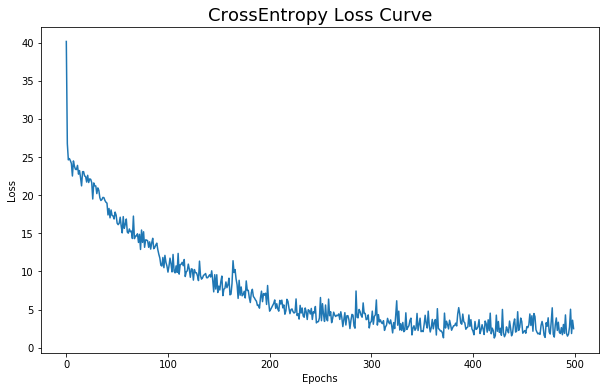

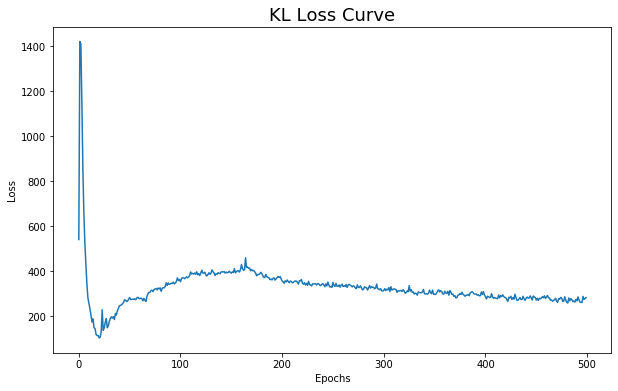

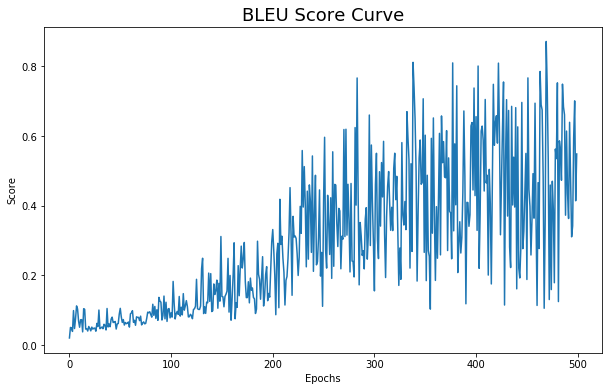

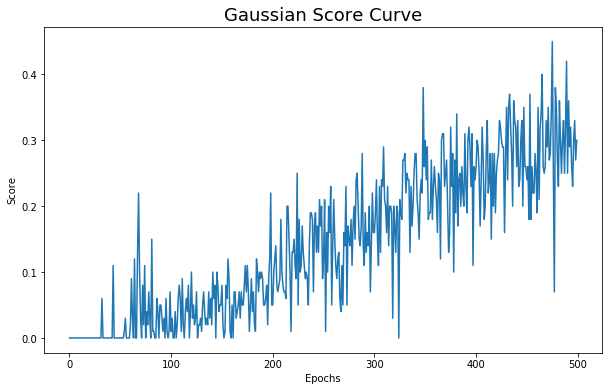

In [25]:
encoder1 = EncoderRNN(vocab_size, hidden_size, laten_size, condition_size).to(device)
decoder1 = DecoderRNN(laten_size, hidden_size, vocab_size, condition_size).to(device)
vocab = Vocabuary()
scores, losses = trainIters(encoder1, decoder1, vocab, 500, print_every=1, plot_every=1, 
                            batch_size=64, learning_rate=0.05, laten_size=32, condition_size=4, teacher_forcing_ratio=0.6)
show_result(scores, losses)

In [29]:
encoder = torch.load("./models/encoder_0.3300_0.8717_m.ckpt")
decoder = torch.load("./models/decoder_0.3300_0.8717_m.ckpt")
_, _  = evaluate(encoder, decoder, vocab, batch_size=64, plot_pred=True)

['forsave', 'forgaves', 'forgaving', 'forgave']
['unfold', 'unfolds', 'crigning', 'unfold']
['plague', 'plagues', 'plaguing', 'plagued']
['creed', 'creeps', 'creeping', 'creeped']
['crack', 'cracks', 'cracking', 'cracked']
['reshuffle', 'reshuffles', 'reshuffling', 'reshuffled']
['switch', 'switches', 'switching', 'switched']
['transfer', 'transfers', 'traverseing', 'transfered']
['direct', 'directs', 'directing', 'directed']
['brollh', 'broucls', 'brisling', 'broucled']
['plead', 'pleads', 'puelding', 'paused']
['struggle', 'struggles', 'struggling', 'struggled']
['signat', 'signats', 'signating', 'signated']
['soothe', 'suffers', 'suffering', 'suffered']
['coast', 'coasts', 'coasting', 'coasted']
['trangle', 'trangles', 'travgling', 'trangled']
['follow', 'controls', 'following', 'followed']
['excite', 'excites', 'exciting', 'excited']
['snuggle', 'snuggles', 'snuggling', 'snuggled']
['whack', 'whacks', 'flicking', 'whacked']
['excuse', 'excuses', 'excusing', 'excused']
['crush', 'cr

0m 1s (- 12m 36s) (1 0%) CE Loss: 37.5202, KL Loss: 523.7968, BLEU score: 0.04, Gaussian score: 0.00
0m 3s (- 12m 44s) (2 0%) CE Loss: 27.8110, KL Loss: 1188.8833, BLEU score: 0.05, Gaussian score: 0.00
0m 4s (- 12m 55s) (3 0%) CE Loss: 25.6751, KL Loss: 983.7708, BLEU score: 0.10, Gaussian score: 0.00
0m 6s (- 12m 53s) (4 0%) CE Loss: 25.7564, KL Loss: 663.9855, BLEU score: 0.05, Gaussian score: 0.00
0m 7s (- 12m 53s) (5 1%) CE Loss: 24.5117, KL Loss: 432.4830, BLEU score: 0.10, Gaussian score: 0.00
0m 9s (- 12m 49s) (6 1%) CE Loss: 24.7792, KL Loss: 309.4684, BLEU score: 0.06, Gaussian score: 0.00
0m 10s (- 12m 47s) (7 1%) CE Loss: 24.0425, KL Loss: 234.8882, BLEU score: 0.05, Gaussian score: 0.00
0m 12s (- 12m 44s) (8 1%) CE Loss: 22.5210, KL Loss: 183.8396, BLEU score: 0.05, Gaussian score: 0.00
0m 14s (- 12m 44s) (9 1%) CE Loss: 24.6895, KL Loss: 152.5838, BLEU score: 0.05, Gaussian score: 0.00
0m 15s (- 12m 43s) (10 2%) CE Loss: 22.1084, KL Loss: 119.8595, BLEU score: 0.05, Gauss

2m 6s (- 10m 45s) (82 16%) CE Loss: 16.1236, KL Loss: 131.2946, BLEU score: 0.08, Gaussian score: 0.17
2m 8s (- 10m 43s) (83 16%) CE Loss: 17.2698, KL Loss: 141.0967, BLEU score: 0.07, Gaussian score: 0.00
2m 9s (- 10m 42s) (84 16%) CE Loss: 16.2922, KL Loss: 134.9608, BLEU score: 0.07, Gaussian score: 0.00
2m 11s (- 10m 40s) (85 17%) CE Loss: 15.6137, KL Loss: 139.0543, BLEU score: 0.06, Gaussian score: 0.21
2m 12s (- 10m 39s) (86 17%) CE Loss: 15.3169, KL Loss: 130.7782, BLEU score: 0.08, Gaussian score: 0.08
2m 14s (- 10m 37s) (87 17%) CE Loss: 16.6342, KL Loss: 131.1254, BLEU score: 0.05, Gaussian score: 0.13
2m 15s (- 10m 35s) (88 17%) CE Loss: 16.7355, KL Loss: 133.5945, BLEU score: 0.07, Gaussian score: 0.00
2m 17s (- 10m 34s) (89 17%) CE Loss: 14.9847, KL Loss: 131.2527, BLEU score: 0.11, Gaussian score: 0.18
2m 18s (- 10m 32s) (90 18%) CE Loss: 16.1305, KL Loss: 139.8506, BLEU score: 0.06, Gaussian score: 0.00
2m 20s (- 10m 31s) (91 18%) CE Loss: 16.2460, KL Loss: 134.5544, BL

4m 14s (- 8m 56s) (161 32%) CE Loss: 10.8202, KL Loss: 206.0562, BLEU score: 0.14, Gaussian score: 0.02
4m 16s (- 8m 55s) (162 32%) CE Loss: 11.3226, KL Loss: 209.4586, BLEU score: 0.09, Gaussian score: 0.02
4m 18s (- 8m 53s) (163 32%) CE Loss: 11.6224, KL Loss: 212.8969, BLEU score: 0.09, Gaussian score: 0.03
4m 19s (- 8m 52s) (164 32%) CE Loss: 9.5285, KL Loss: 216.7926, BLEU score: 0.17, Gaussian score: 0.06
4m 21s (- 8m 51s) (165 33%) CE Loss: 11.3426, KL Loss: 218.4248, BLEU score: 0.11, Gaussian score: 0.08
4m 23s (- 8m 49s) (166 33%) CE Loss: 11.3627, KL Loss: 226.4295, BLEU score: 0.08, Gaussian score: 0.01
4m 24s (- 8m 48s) (167 33%) CE Loss: 9.3856, KL Loss: 222.5717, BLEU score: 0.09, Gaussian score: 0.03
4m 26s (- 8m 46s) (168 33%) CE Loss: 10.6207, KL Loss: 221.0807, BLEU score: 0.08, Gaussian score: 0.17
4m 28s (- 8m 45s) (169 33%) CE Loss: 9.4313, KL Loss: 229.8953, BLEU score: 0.12, Gaussian score: 0.04
4m 29s (- 8m 43s) (170 34%) CE Loss: 10.1419, KL Loss: 228.7843, BL

6m 26s (- 6m 55s) (241 48%) CE Loss: 4.7486, KL Loss: 251.0837, BLEU score: 0.12, Gaussian score: 0.06
6m 28s (- 6m 53s) (242 48%) CE Loss: 4.8100, KL Loss: 254.5757, BLEU score: 0.23, Gaussian score: 0.19
6m 29s (- 6m 52s) (243 48%) CE Loss: 4.6398, KL Loss: 255.3331, BLEU score: 0.36, Gaussian score: 0.18
6m 31s (- 6m 50s) (244 48%) CE Loss: 3.6759, KL Loss: 248.9169, BLEU score: 0.64, Gaussian score: 0.22
6m 32s (- 6m 48s) (245 49%) CE Loss: 3.8760, KL Loss: 246.9977, BLEU score: 0.12, Gaussian score: 0.14
6m 34s (- 6m 47s) (246 49%) CE Loss: 4.5016, KL Loss: 252.0082, BLEU score: 0.45, Gaussian score: 0.08
6m 35s (- 6m 45s) (247 49%) CE Loss: 4.1079, KL Loss: 252.6749, BLEU score: 0.33, Gaussian score: 0.14
6m 37s (- 6m 44s) (248 49%) CE Loss: 3.6335, KL Loss: 252.4615, BLEU score: 0.26, Gaussian score: 0.18
6m 39s (- 6m 42s) (249 49%) CE Loss: 4.0285, KL Loss: 250.0838, BLEU score: 0.18, Gaussian score: 0.14
6m 40s (- 6m 40s) (250 50%) CE Loss: 4.7877, KL Loss: 252.5827, BLEU scor

/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


7m 23s (- 5m 57s) (277 55%) CE Loss: 2.2002, KL Loss: 256.6737, BLEU score: 0.43, Gaussian score: 0.24
7m 25s (- 5m 55s) (278 55%) CE Loss: 3.5073, KL Loss: 256.7156, BLEU score: 0.33, Gaussian score: 0.19
7m 26s (- 5m 53s) (279 55%) CE Loss: 2.5663, KL Loss: 254.2366, BLEU score: 0.24, Gaussian score: 0.22
7m 28s (- 5m 52s) (280 56%) CE Loss: 4.0879, KL Loss: 254.2454, BLEU score: 0.37, Gaussian score: 0.24
7m 29s (- 5m 50s) (281 56%) CE Loss: 2.9749, KL Loss: 257.5053, BLEU score: 0.67, Gaussian score: 0.18
7m 31s (- 5m 48s) (282 56%) CE Loss: 2.6502, KL Loss: 253.5381, BLEU score: 0.33, Gaussian score: 0.22
7m 32s (- 5m 47s) (283 56%) CE Loss: 3.0618, KL Loss: 252.7948, BLEU score: 0.41, Gaussian score: 0.22
7m 34s (- 5m 45s) (284 56%) CE Loss: 2.6260, KL Loss: 254.7504, BLEU score: 0.34, Gaussian score: 0.22
7m 35s (- 5m 43s) (285 56%) CE Loss: 3.5001, KL Loss: 256.5725, BLEU score: 0.22, Gaussian score: 0.03
7m 37s (- 5m 41s) (286 57%) CE Loss: 3.9206, KL Loss: 258.5759, BLEU scor

Model save...
9m 18s (- 3m 50s) (354 70%) CE Loss: 1.5060, KL Loss: 252.5868, BLEU score: 0.69, Gaussian score: 0.34
9m 20s (- 3m 48s) (355 71%) CE Loss: 1.4575, KL Loss: 248.7004, BLEU score: 0.15, Gaussian score: 0.29
9m 21s (- 3m 47s) (356 71%) CE Loss: 1.6028, KL Loss: 251.0807, BLEU score: 0.69, Gaussian score: 0.21
9m 22s (- 3m 45s) (357 71%) CE Loss: 2.1733, KL Loss: 252.6492, BLEU score: 0.33, Gaussian score: 0.14
9m 24s (- 3m 43s) (358 71%) CE Loss: 3.0889, KL Loss: 258.7216, BLEU score: 0.38, Gaussian score: 0.42
9m 25s (- 3m 42s) (359 71%) CE Loss: 1.6448, KL Loss: 255.6725, BLEU score: 0.66, Gaussian score: 0.23
9m 27s (- 3m 40s) (360 72%) CE Loss: 1.9179, KL Loss: 251.2444, BLEU score: 0.35, Gaussian score: 0.19
Model save...
9m 28s (- 3m 39s) (361 72%) CE Loss: 2.1905, KL Loss: 255.2639, BLEU score: 0.44, Gaussian score: 0.31
Model save...
9m 30s (- 3m 37s) (362 72%) CE Loss: 2.2299, KL Loss: 257.0021, BLEU score: 0.53, Gaussian score: 0.30
Model save...
9m 31s (- 3m 35s)

Model save...
11m 9s (- 1m 52s) (428 85%) CE Loss: 1.2871, KL Loss: 245.6920, BLEU score: 0.60, Gaussian score: 0.32
Model save...
11m 11s (- 1m 51s) (429 85%) CE Loss: 1.1949, KL Loss: 245.5018, BLEU score: 0.61, Gaussian score: 0.34
Model save...
11m 12s (- 1m 49s) (430 86%) CE Loss: 2.1646, KL Loss: 256.4925, BLEU score: 0.83, Gaussian score: 0.32
Model save...
11m 14s (- 1m 47s) (431 86%) CE Loss: 0.9449, KL Loss: 245.4199, BLEU score: 0.56, Gaussian score: 0.41
Model save...
11m 15s (- 1m 46s) (432 86%) CE Loss: 1.1354, KL Loss: 242.5063, BLEU score: 0.65, Gaussian score: 0.40
11m 17s (- 1m 44s) (433 86%) CE Loss: 1.3382, KL Loss: 243.8892, BLEU score: 0.44, Gaussian score: 0.20
11m 18s (- 1m 43s) (434 86%) CE Loss: 1.9937, KL Loss: 254.4694, BLEU score: 0.27, Gaussian score: 0.25
11m 20s (- 1m 41s) (435 87%) CE Loss: 1.5375, KL Loss: 251.0436, BLEU score: 0.19, Gaussian score: 0.24
11m 21s (- 1m 40s) (436 87%) CE Loss: 1.3653, KL Loss: 251.8377, BLEU score: 0.28, Gaussian score: 

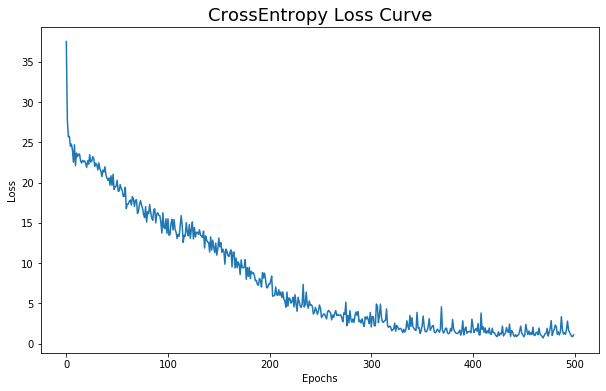

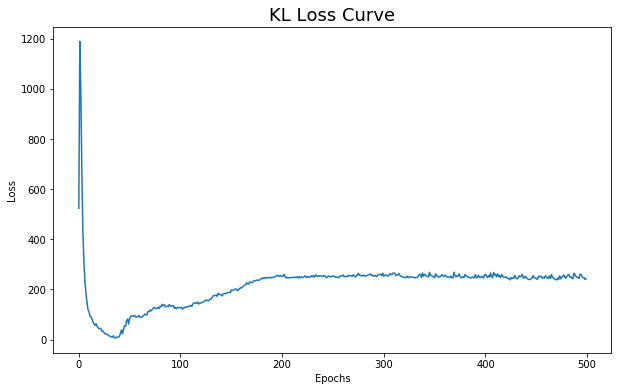

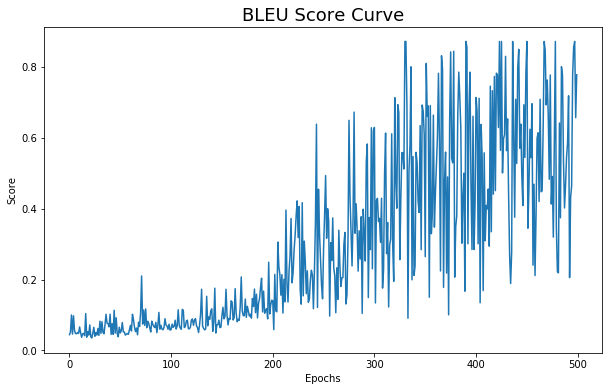

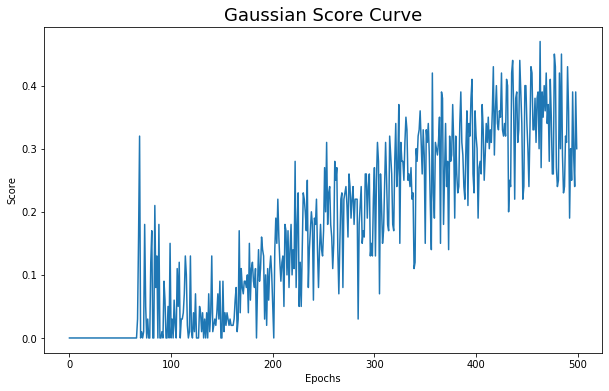

In [33]:
encoder2 = EncoderRNN(vocab_size, hidden_size, laten_size, condition_size).to(device)
decoder2 = DecoderRNN(laten_size, hidden_size, vocab_size, condition_size).to(device)
vocab = Vocabuary()
scores, losses = trainIters(encoder2, decoder2, vocab, 500, print_every=1, plot_every=1, 
                            batch_size=64, learning_rate=0.05, laten_size=32, condition_size=4, teacher_forcing_ratio=0.6)
show_result(scores, losses)

In [39]:
encoder = torch.load("./models/encoder_0.4300_0.8717_c.ckpt")
decoder = torch.load("./models/decoder_0.4300_0.8717_c.ckpt")
_, _  = evaluate(encoder, decoder, vocab, batch_size=64, plot_pred=True)

['laann', 'laannes', 'laanning', 'laanned']
['plague', 'plagues', 'plaguing', 'plagued']
['allegin', 'alleges', 'alleging', 'alleged']
['leer', 'leers', 'leering', 'leered']
['sketch', 'sketches', 'sketching', 'sketched']
['augnounce', 'augnounces', 'augnouncing', 'augnounced']
['entine', 'entines', 'entining', 'entined']
['object', 'softens', 'softening', 'softened']
['affirm', 'affirms', 'affirming', 'affirmed']
['twitch', 'twisces', 'twiscing', 'twisced']
['inflict', 'inflicts', 'inflicting', 'inflicted']
['stagger', 'shudders', 'staggering', 'staggered']
['convene', 'convenes', 'conveying', 'conveyed']
['wear', 'wents', 'wearing', 'went']
['parode', 'parodes', 'paroding', 'paroded']
['prevent', 'preaches', 'preaching', 'preached']
['collapse', 'collapses', 'collapsing', 'collapsed']
['desniee', 'desniees', 'desniling', 'desniled']
['knock', 'knocks', 'knocking', 'knocked']
['ferment', 'ferments', 'fermenting', 'fermented']
['desende', 'declines', 'declining', 'declined']
['estimate